<a href="https://colab.research.google.com/github/secutron/Practice_Ignite/blob/main/A_1_x2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A.1.5. 기타 기능 추가 확인

 본 절에서는 기존 코드를 좀 더 수정하여, 아래와 같이 confusion matrix와 손실값 추세 그래프 및 샘플 예측 결과 확인 등을 수행할 수 있도록 새로운 코드를 작성하였다. 기존 파이토치 사용자의 경우 이그나이트 기본 흐름을 유지한 상태에서, 자유로운 응용이 가능함을 확인할 수 있다.
 
<div align="center">
<img width=450 src="https://i.imgur.com/3ZpcPiS.png"/>
</div>

<div align="center">
<img width=250 src="https://i.imgur.com/w2t8Fd1.png"/>
</div>

<div align="center">
<img width=800 src="https://i.imgur.com/OW9DVPd.png"/>
</div>



In [1]:
import os

gpu_gtg = False
if int(os.environ.get("COLAB_GPU")) > 0:
    gpu_gtg = "COLAB_GPU" in os.environ

tpu_gtg = "COLAB_TPU_ADDR" in os.environ

if tpu_gtg: # tpu
    print("TPU")
    #VERSION = "nightly"

    # https://github.com/pytorch/builder/pull/750
    VERSION = "20210304" # was 20200607" 

    !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
    !python pytorch-xla-env-setup.py --version $VERSION

TPU
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5116  100  5116    0     0  34802      0 --:--:-- --:--:-- --:--:-- 34802
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20210304 ...
Found existing installation: torch 1.9.0+cu102
     |████████████████████████████████| 57 kB 2.8 MB/s 
Uninstalling torch-1.9.0+cu102:
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.278 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompa

In [2]:
# https://pypi.org/project/pytorch-ignite/0.5.0.dev20210719/
!pip install --pre pytorch-ignite
#!pip install pytorch-ignite==0.5.0.dev20210719
#!pip install pytorch-gradcam

     |████████████████████████████████| 233 kB 5.3 MB/s 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
#from tqdm import tqdm
import seaborn as sns

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

import torchsummary

#from gradcam import GradCAM
#from gradcam.utils import visualize_cam

import ignite
import ignite.distributed as idist
from ignite.contrib.engines import common
from ignite.contrib.handlers import PiecewiseLinear
from ignite.engine import Engine, Events, create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.utils import manual_seed, setup_logger

In [4]:
#!pip list

In [5]:
def log_basic_info(logger, config):
    logger.info(f"Train {config['model']} on CIFAR10")
    logger.info(f"- PyTorch version: {torch.__version__}")
    logger.info(f"- Ignite version: {ignite.__version__}")
    
    if gpu_gtg:
        # explicitly import cudnn as
        # torch.backends.cudnn can not be pickled with hvd spawning procs
        from torch.backends import cudnn

        logger.info(f"- GPU Device: {torch.cuda.get_device_name(idist.get_local_rank())}")
        logger.info(f"- CUDA version: {torch.version.cuda}")
        logger.info(f"- CUDNN version: {cudnn.version()}")

    logger.info("\n")
    logger.info("Configuration:")
    for key, value in config.items():
        logger.info(f"\t{key}: {value}")
    logger.info("\n")

    if idist.get_world_size() > 1:
        logger.info("\nDistributed setting:")
        logger.info(f"\tbackend: {idist.backend()}")
        logger.info(f"\tworld size: {idist.get_world_size()}")
        logger.info("\n")

In [6]:
classes_list = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def training(local_rank, config, queue, **kwargs):
    print("local rank: ", local_rank)

    rank = idist.get_rank()
    print("----------> ", rank, ': run with config:', config, '- backend=', idist.backend())

    # For reproducibility
    # https://github.com/pytorch/pytorch/issues/2517
    torch.manual_seed(config["seed"] + rank)
    np.random.seed(config["seed"] + rank) # torchvision.transform 사용 시 잊지 말 것
    if gpu_gtg:
        torch.cuda.manual_seed(config["seed"] + rank)
        torch.cuda.manual_seed_all(config["seed"] + rank)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False  


    #logger = setup_logger(name="hkim", distributed_rank=local_rank)
    #log_basic_info(logger, config)

   ###########################################################
   # 데이터 준비
    train_transform = transforms.Compose(
    [
        transforms.Pad(4),
        transforms.RandomCrop(32, fill=128),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
    )

    test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),])

    if idist.get_local_rank() > 0:
        if config["verbose_loader"]:
            print(f"{idist.get_local_rank()} - rank non-zero barrier check") 
        idist.barrier()

    trainset = torchvision.datasets.CIFAR10(root=config["data_path"], train=True, download=True, transform=train_transform)
    testset = torchvision.datasets.CIFAR10(root=config["data_path"], train=False, download=True, transform=test_transform)

    # 배치 하나만
    #trainset.data = trainset.data[0:512]

    if config["verbose_loader"]:
        print(f"{idist.get_local_rank()} - dataset ready")

    if idist.get_local_rank() == 0:
        if config["verbose_loader"]:
            print(f"{idist.get_local_rank()} - rank zero barrier check")
        idist.barrier()

    trainloader = idist.auto_dataloader(trainset, batch_size=config["batch_size"], shuffle=True, num_workers=config["num_workers"], drop_last=True)
    testloader = idist.auto_dataloader(testset, batch_size=config["batch_size"], shuffle=False, num_workers=config["num_workers"],)

    if config["verbose_loader"]:
        print(f"{idist.get_local_rank()} - dataloader ready")

    if config["verbose_loader"]:
        batch = next(iter(testloader))
        print(f"{idist.get_local_rank()} - \n {batch[1]}")      




    ###########################################################
    # 모델, 옵티마이저, 로스, 트레이너, 이밸류에이터

    num_classes = 10
    model = models.resnet18(num_classes = num_classes)
    
    #num_classes = 10
    #num_ftrs = model.fc.in_features
    #model.fc = nn.Linear(num_ftrs, num_classes)
    
    model = idist.auto_model(model)

    #print(model)



    #from torchsummary import summary
    #summary(model, input_size=(3,32,32), device=idist.device().type)



    optimizer = optim.Adam(model.parameters(), lr=0.001)
    #optimizer = idist.auto_optim(optimizer)


    # criterion = nn.NLLLoss().to(idist.device())
    criterion = nn.CrossEntropyLoss().to(idist.device())


    print("before trainer: ", idist.device())
    trainer = create_supervised_trainer(model, optimizer, criterion, device=idist.device())
    trainer.logger = setup_logger("hkim-trainer")

    metrics = {
        'accuracy':Accuracy(),
        'ce':Loss(criterion),
        'cm':ConfusionMatrix(num_classes=num_classes)
    }

    train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=idist.device())
    train_evaluator.logger = setup_logger("hkim-train_evaluator")
    val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=idist.device())
    val_evaluator.logger = setup_logger("hkim-val_evaluator")

    training_history = {'accuracy':[],'loss':[]}
    validation_history = {'accuracy':[],'loss':[]}
    last_epoch = []

    # track a running average of the scalar loss output for each batch.
    RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')


    

    ###########################################################
    # 조기 종료 - val set에서 loss 값이 10 epoch 이상 줄어들지 않으면....
    def score_function(engine):
        val_loss = engine.state.metrics['ce']
        return -val_loss

    def early_stop():
        handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
    
    val_evaluator.add_event_handler(Events.COMPLETED, early_stop)   


    ###########################################################
    # 체크포인트....
    #checkpointer = ModelCheckpoint('./saved_models', 'cifar10', n_saved=2, create_dir=True, save_as_state_dict=True, require_empty=False)
    checkpointer = ModelCheckpoint('./saved_models', 'cifar10', n_saved=2, create_dir=True, require_empty=False)
    trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'cifar10': model})



    ###########################################################
    # 그 외 이벤트
    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(trainer):
        train_evaluator.run(trainloader)
        metrics = train_evaluator.state.metrics
        accuracy = metrics['accuracy']*100
        loss = metrics['ce']
        last_epoch.append(0)
        training_history['accuracy'].append(accuracy)
        training_history['loss'].append(loss)
        print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
            .format(trainer.state.epoch, accuracy, loss))

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_results(trainer):
        val_evaluator.run(testloader)
        metrics = val_evaluator.state.metrics
        accuracy = metrics['accuracy']*100
        loss = metrics['ce']
        validation_history['accuracy'].append(accuracy)
        validation_history['loss'].append(loss)
        print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
            .format(trainer.state.epoch, accuracy, loss))

    # confusion matrix
    @trainer.on(Events.COMPLETED)
    def log_confusion_matrix(trainer):
        val_evaluator.run(testloader)
        metrics = val_evaluator.state.metrics
        cm = metrics['cm']
        print(cm)
        return
        cm = cm.numpy()
        cm = cm.astype(int)
        classes = classes_list
        fig, ax = plt.subplots(figsize=(10,10))  
        ax= plt.subplot()
        sns.heatmap(cm, annot=True, ax = ax,fmt="d")
        # labels, title and ticks
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels') 
        ax.set_title('Confusion Matrix') 
        ax.xaxis.set_ticklabels(classes,rotation=90)
        ax.yaxis.set_ticklabels(classes,rotation=0)



    print(f"{idist.get_local_rank()} - trainer")     



    print(f"{idist.get_local_rank()} - trainer.run begins")     
    trainer.run(trainloader, max_epochs=config["num_epochs"])
    print(f"{idist.get_local_rank()} - trainer.run ends") 
    
    if idist.get_local_rank() == 0:
        print(f"queue begins")     
        metrics = val_evaluator.state.metrics
        # 큐에 텐서를 넣을 수 없다!!! 
        import copy
        tmp = copy.deepcopy(metrics['cm'].numpy())
        queue.put(tmp)
        queue.put(training_history)
        queue.put(validation_history)
        queue.put(last_epoch)

        print(queue.qsize()) 

In [7]:
config = {
    "seed": 543,
    "data_path" : "./cifar10",
    "output_path" : "./output-cifar10/",
    "model" : "resnet18",
    "batch_size" : 512,
    "momentum" : 0.9,
    "weight_decay" : 1e-4,
    "num_workers" : 2,
    "num_epochs" : 5,
    "learning_rate" : 0.4,
    "num_warmup_epochs" : 4,
    "validate_every" : 3, 
    "checkpoint_every" : 1000,
    "backend" : None, 
    "resume_from" : None, 
    "log_every_iters" : 15,
    "nproc_per_node" : None, 
    "stop_iteration" : None, 
    "with_amp" : False,
    "log_interval" : 10,
    "verbose_set" : False,
    "verbose_set2" : False,
    "verbose_loader" : False

}

if not (tpu_gtg or gpu_gtg): # cpu
    config["backend"] = 'gloo'
    config["nproc_per_node"] = 8
elif gpu_gtg: # gpu
    config["backend"] = 'nccl'
    config["nproc_per_node"] = 1
elif tpu_gtg: # tpu
    config["backend"] = 'xla-tpu'
    config["nproc_per_node"] = 8
else: # error
    raise RuntimeError("Unknown environment: tpu_gtg {}, gpu_gtg {}".format(tpu_gtg, gpu_gtg))

if config["backend"] == "xla-tpu" and config["with_amp"]:
    raise RuntimeError("The value of with_amp should be False if backend is xla")


dist_configs = {'nproc_per_node': config["nproc_per_node"], "start_method": "fork"}  # or dist_configs = {...}

from multiprocessing import Queue
queue = Queue()
#queue = []

with idist.Parallel(backend=config["backend"], **dist_configs) as parallel:
    parallel.run(training, config, queue, a=1, b=1)

    print(queue.qsize())
    cm = queue.get()
    training_history = queue.get()
    validation_history = queue.get()
    last_epoch = queue.get()


#print(training_histroy)
#print(validation_histroy)
#print(last_epoch)

2021-09-13 11:45:55,455 ignite.distributed.launcher.Parallel INFO: Initialized distributed launcher with backend: 'xla-tpu'
2021-09-13 11:45:55,457 ignite.distributed.launcher.Parallel INFO: - Parameters to spawn processes: 
	nproc_per_node: 8
	nnodes: 1
	node_rank: 0
	start_method: fork
2021-09-13 11:45:55,458 ignite.distributed.launcher.Parallel INFO: Spawn function '<function training at 0x7fe8e220c200>' in 8 processes


local rank:  2
local rank:  1
local rank:  7
local rank:  0
---------->  1 : run with config: {'seed': 543, 'data_path': './cifar10', 'output_path': './output-cifar10/', 'model': 'resnet18', 'batch_size': 512, 'momentum': 0.9, 'weight_decay': 0.0001, 'num_workers': 2, 'num_epochs': 5, 'learning_rate': 0.4, 'num_warmup_epochs': 4, 'validate_every': 3, 'checkpoint_every': 1000, 'backend': 'xla-tpu', 'resume_from': None, 'log_every_iters': 15, 'nproc_per_node': 8, 'stop_iteration': None, 'with_amp': False, 'log_interval': 10, 'verbose_set': False, 'verbose_set2': False, 'verbose_loader': False} - backend= xla-tpu
---------->  7 : run with config: {'seed': 543, 'data_path': './cifar10', 'output_path': './output-cifar10/', 'model': 'resnet18', 'batch_size': 512, 'momentum': 0.9, 'weight_decay': 0.0001, 'num_workers': 2, 'num_epochs': 5, 'learning_rate': 0.4, 'num_warmup_epochs': 4, 'validate_every': 3, 'checkpoint_every': 1000, 'backend': 'xla-tpu', 'resume_from': None, 'log_every_iters': 1

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


2021-09-13 11:47:24,458 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset 'Dataset CIFAR10': 
	{'batch_size': 64, 'num_workers': 2, 'drop_last': True, 'sampler': <torch.utils.data.distributed.DistributedSampler object at 0x7fe8a53a9f50>, 'pin_memory': False}
2021-09-13 11:47:24,499 ignite.distributed.auto.auto_dataloader INFO: DataLoader is wrapped by `MpDeviceLoader` on XLA
2021-09-13 11:47:24,526 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset 'Dataset CIFAR10': 
	{'batch_size': 64, 'num_workers': 2, 'sampler': <torch.utils.data.distributed.DistributedSampler object at 0x7fe8a53a95d0>, 'pin_memory': False}
2021-09-13 11:47:24,547 ignite.distributed.auto.auto_dataloader INFO: DataLoader is wrapped by `MpDeviceLoader` on XLA


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
before trainer:  xla:1
0 - trainer
Files already downloaded and verified
0 - trainer.run begins


2021-09-13 11:47:26,632 hkim-trainer INFO: Engine run starting with max_epochs=5.


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
before trainer:  xla:0
4 - trainer
4 - trainer.run begins
before trainer:  xla:0
1 - trainer
1 - trainer.run begins
before trainer:  xla:0
before trainer:  xla:0
7 - trainer
7 - trainer.run begins
before trainer:  xla:0
5 - trainer
3 - trainer
3 - trainer.run begins
5 - trainer.run begins
before trainer:  xla:0
2 - trainer
2 - trainer.run begins
before trainer:  xla:0
6 - trainer
6 - trainer.run begins


2021-09-13 11:48:19,778 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.
2021-09-13 11:48:45,569 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:26


Training Results - Epoch: 1  Avg accuracy: 33.22 Avg loss: 1.86
Training Results - Epoch: 1  Avg accuracy: 33.22 Avg loss: 1.86
Training Results - Epoch: 1  Avg accuracy: 33.22 Avg loss: 1.86
Training Results - Epoch: 1  Avg accuracy: 33.22 Avg loss: 1.86
Training Results - Epoch: 1  Avg accuracy: 33.22 Avg loss: 1.86
Training Results - Epoch: 1  Avg accuracy: 33.22 Avg loss: 1.86


2021-09-13 11:48:45,585 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:26


Training Results - Epoch: 1  Avg accuracy: 33.22 Avg loss: 1.86
Training Results - Epoch: 1  Avg accuracy: 33.22 Avg loss: 1.86


2021-09-13 11:48:45,619 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.
2021-09-13 11:48:51,894 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06


Validation Results - Epoch: 1  Avg accuracy: 34.54 Avg loss: 1.83
Validation Results - Epoch: 1  Avg accuracy: 34.54 Avg loss: 1.83
Validation Results - Epoch: 1  Avg accuracy: 34.54 Avg loss: 1.83
Validation Results - Epoch: 1  Avg accuracy: 34.54 Avg loss: 1.83
Validation Results - Epoch: 1  Avg accuracy: 34.54 Avg loss: 1.83
Validation Results - Epoch: 1  Avg accuracy: 34.54 Avg loss: 1.83


2021-09-13 11:48:51,922 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:06


Validation Results - Epoch: 1  Avg accuracy: 34.54 Avg loss: 1.83
Validation Results - Epoch: 1  Avg accuracy: 34.54 Avg loss: 1.83


2021-09-13 11:48:51,948 hkim-trainer INFO: Epoch[1] Complete. Time taken: 00:01:25
2021-09-13 11:49:24,896 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 2  Avg accuracy: 39.15 Avg loss: 1.66
Training Results - Epoch: 2  Avg accuracy: 39.15 Avg loss: 1.66
Training Results - Epoch: 2  Avg accuracy: 39.15 Avg loss: 1.66
Training Results - Epoch: 2  Avg accuracy: 39.15 Avg loss: 1.66
Training Results - Epoch: 2  Avg accuracy: 39.15 Avg loss: 1.66
Training Results - Epoch: 2  Avg accuracy: 39.15 Avg loss: 1.66
Training Results - Epoch: 2  Avg accuracy: 39.15 Avg loss: 1.66


2021-09-13 11:49:49,232 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:24
2021-09-13 11:49:49,265 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:24


Training Results - Epoch: 2  Avg accuracy: 39.15 Avg loss: 1.66


2021-09-13 11:49:49,302 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 2  Avg accuracy: 39.99 Avg loss: 1.65


2021-09-13 11:49:53,650 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04


Validation Results - Epoch: 2  Avg accuracy: 39.99 Avg loss: 1.65
Validation Results - Epoch: 2  Avg accuracy: 39.99 Avg loss: 1.65
Validation Results - Epoch: 2  Avg accuracy: 39.99 Avg loss: 1.65
Validation Results - Epoch: 2  Avg accuracy: 39.99 Avg loss: 1.65
Validation Results - Epoch: 2  Avg accuracy: 39.99 Avg loss: 1.65
Validation Results - Epoch: 2  Avg accuracy: 39.99 Avg loss: 1.65


2021-09-13 11:49:53,659 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 2  Avg accuracy: 39.99 Avg loss: 1.65


2021-09-13 11:49:53,721 hkim-trainer INFO: Epoch[2] Complete. Time taken: 00:01:02
2021-09-13 11:50:25,582 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 3  Avg accuracy: 43.07 Avg loss: 1.54
Training Results - Epoch: 3  Avg accuracy: 43.07 Avg loss: 1.54
Training Results - Epoch: 3  Avg accuracy: 43.07 Avg loss: 1.54
Training Results - Epoch: 3  Avg accuracy: 43.07 Avg loss: 1.54


2021-09-13 11:50:49,570 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:24


Training Results - Epoch: 3  Avg accuracy: 43.07 Avg loss: 1.54
Training Results - Epoch: 3  Avg accuracy: 43.07 Avg loss: 1.54
Training Results - Epoch: 3  Avg accuracy: 43.07 Avg loss: 1.54


2021-09-13 11:50:49,590 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:24


Training Results - Epoch: 3  Avg accuracy: 43.07 Avg loss: 1.54


2021-09-13 11:50:49,617 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 3  Avg accuracy: 42.87 Avg loss: 1.54


2021-09-13 11:50:53,891 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04


Validation Results - Epoch: 3  Avg accuracy: 42.87 Avg loss: 1.54
Validation Results - Epoch: 3  Avg accuracy: 42.87 Avg loss: 1.54
Validation Results - Epoch: 3  Avg accuracy: 42.87 Avg loss: 1.54
Validation Results - Epoch: 3  Avg accuracy: 42.87 Avg loss: 1.54


2021-09-13 11:50:53,904 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 3  Avg accuracy: 42.87 Avg loss: 1.54
Validation Results - Epoch: 3  Avg accuracy: 42.87 Avg loss: 1.54
Validation Results - Epoch: 3  Avg accuracy: 42.87 Avg loss: 1.54


2021-09-13 11:50:53,925 hkim-trainer INFO: Epoch[3] Complete. Time taken: 00:01:00
2021-09-13 11:51:25,320 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.


Training Results - Epoch: 4  Avg accuracy: 46.03 Avg loss: 1.48
Training Results - Epoch: 4  Avg accuracy: 46.03 Avg loss: 1.48
Training Results - Epoch: 4  Avg accuracy: 46.03 Avg loss: 1.48


2021-09-13 11:51:49,154 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:24


Training Results - Epoch: 4  Avg accuracy: 46.03 Avg loss: 1.48
Training Results - Epoch: 4  Avg accuracy: 46.03 Avg loss: 1.48
Training Results - Epoch: 4  Avg accuracy: 46.03 Avg loss: 1.48
Training Results - Epoch: 4  Avg accuracy: 46.03 Avg loss: 1.48


2021-09-13 11:51:49,167 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:24


Training Results - Epoch: 4  Avg accuracy: 46.03 Avg loss: 1.48


2021-09-13 11:51:49,198 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 4  Avg accuracy: 45.99 Avg loss: 1.49


2021-09-13 11:51:53,424 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04


Validation Results - Epoch: 4  Avg accuracy: 45.99 Avg loss: 1.49
Validation Results - Epoch: 4  Avg accuracy: 45.99 Avg loss: 1.49
Validation Results - Epoch: 4  Avg accuracy: 45.99 Avg loss: 1.49
Validation Results - Epoch: 4  Avg accuracy: 45.99 Avg loss: 1.49
Validation Results - Epoch: 4  Avg accuracy: 45.99 Avg loss: 1.49
Validation Results - Epoch: 4  Avg accuracy: 45.99 Avg loss: 1.49


2021-09-13 11:51:53,432 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 4  Avg accuracy: 45.99 Avg loss: 1.49


2021-09-13 11:51:53,486 hkim-trainer INFO: Epoch[4] Complete. Time taken: 00:00:60
2021-09-13 11:52:24,822 hkim-train_evaluator INFO: Engine run starting with max_epochs=1.
2021-09-13 11:52:48,715 hkim-train_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:24


Training Results - Epoch: 5  Avg accuracy: 48.40 Avg loss: 1.41
Training Results - Epoch: 5  Avg accuracy: 48.40 Avg loss: 1.41
Training Results - Epoch: 5  Avg accuracy: 48.40 Avg loss: 1.41
Training Results - Epoch: 5  Avg accuracy: 48.40 Avg loss: 1.41
Training Results - Epoch: 5  Avg accuracy: 48.40 Avg loss: 1.41
Training Results - Epoch: 5  Avg accuracy: 48.40 Avg loss: 1.41
Training Results - Epoch: 5  Avg accuracy: 48.40 Avg loss: 1.41


2021-09-13 11:52:48,720 hkim-train_evaluator INFO: Engine run complete. Time taken: 00:00:24


Training Results - Epoch: 5  Avg accuracy: 48.40 Avg loss: 1.41


2021-09-13 11:52:48,757 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


Validation Results - Epoch: 5  Avg accuracy: 46.39 Avg loss: 1.46
Validation Results - Epoch: 5  Avg accuracy: 46.39 Avg loss: 1.46


2021-09-13 11:52:53,004 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04


Validation Results - Epoch: 5  Avg accuracy: 46.39 Avg loss: 1.46
Validation Results - Epoch: 5  Avg accuracy: 46.39 Avg loss: 1.46
Validation Results - Epoch: 5  Avg accuracy: 46.39 Avg loss: 1.46
Validation Results - Epoch: 5  Avg accuracy: 46.39 Avg loss: 1.46
Validation Results - Epoch: 5  Avg accuracy: 46.39 Avg loss: 1.46


2021-09-13 11:52:53,024 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


Validation Results - Epoch: 5  Avg accuracy: 46.39 Avg loss: 1.46


2021-09-13 11:52:53,054 hkim-trainer INFO: Epoch[5] Complete. Time taken: 00:00:60
2021-09-13 11:52:53,065 hkim-val_evaluator INFO: Engine run starting with max_epochs=1.


tensor([[619,  60,  64,  17,  21,  25,  17,  13, 122,  42],
        [ 92, 636,  16,  17,   6,  27,  10,  14,  52, 130],
        [128,  28, 299,  52, 182, 154,  64,  47,  28,  18],
        [ 59,  35,  90, 222,  69, 351,  73,  46,  16,  39],
        [ 62,  16, 162,  49, 387, 112,  90,  93,  17,  12],
        [ 34,  12,  88, 133,  66, 531,  29,  77,  15,  15],
        [ 17,  33,  96,  83, 107,  95, 521,  22,   6,  20],
        [ 41,  30,  34,  48,  81, 168,  16, 525,   8,  49],
        [275,  90,  24,  20,   7,  18,   6,  11, 493,  56],
        [ 87, 297,  20,  21,   9,  24,  19,  34,  83, 406]])tensor([[619,  60,  64,  17,  21,  25,  17,  13, 122,  42],
        [ 92, 636,  16,  17,   6,  27,  10,  14,  52, 130],
        [128,  28, 299,  52, 182, 154,  64,  47,  28,  18],
        [ 59,  35,  90, 222,  69, 351,  73,  46,  16,  39],
        [ 62,  16, 162,  49, 387, 112,  90,  93,  17,  12],
        [ 34,  12,  88, 133,  66, 531,  29,  77,  15,  15],
        [ 17,  33,  96,  83, 107,  95, 5

2021-09-13 11:52:57,244 hkim-val_evaluator INFO: Epoch[1] Complete. Time taken: 00:00:04



6 - trainer.run ends
1 - trainer.run ends
7 - trainer.run ends

tensor([[619,  60,  64,  17,  21,  25,  17,  13, 122,  42],
        [ 92, 636,  16,  17,   6,  27,  10,  14,  52, 130],
        [128,  28, 299,  52, 182, 154,  64,  47,  28,  18],
        [ 59,  35,  90, 222,  69, 351,  73,  46,  16,  39],
        [ 62,  16, 162,  49, 387, 112,  90,  93,  17,  12],
        [ 34,  12,  88, 133,  66, 531,  29,  77,  15,  15],
        [ 17,  33,  96,  83, 107,  95, 521,  22,   6,  20],
        [ 41,  30,  34,  48,  81, 168,  16, 525,   8,  49],
        [275,  90,  24,  20,   7,  18,   6,  11, 493,  56],
        [ 87, 297,  20,  21,   9,  24,  19,  34,  83, 406]])
tensor([[619,  60,  64,  17,  21,  25,  17,  13, 122,  42],
        [ 92, 636,  16,  17,   6,  27,  10,  14,  52, 130],
        [128,  28, 299,  52, 182, 154,  64,  47,  28,  18],
        [ 59,  35,  90, 222,  69, 351,  73,  46,  16,  39],
        [ 62,  16, 162,  49, 387, 112,  90,  93,  17,  12],
        [ 34,  12,  88, 133,  66, 

2021-09-13 11:52:57,267 hkim-val_evaluator INFO: Engine run complete. Time taken: 00:00:04


5 - trainer.run ends

tensor([[619,  60,  64,  17,  21,  25,  17,  13, 122,  42],
        [ 92, 636,  16,  17,   6,  27,  10,  14,  52, 130],
        [128,  28, 299,  52, 182, 154,  64,  47,  28,  18],
        [ 59,  35,  90, 222,  69, 351,  73,  46,  16,  39],
        [ 62,  16, 162,  49, 387, 112,  90,  93,  17,  12],
        [ 34,  12,  88, 133,  66, 531,  29,  77,  15,  15],
        [ 17,  33,  96,  83, 107,  95, 521,  22,   6,  20],
        [ 41,  30,  34,  48,  81, 168,  16, 525,   8,  49],
        [275,  90,  24,  20,   7,  18,   6,  11, 493,  56],
        [ 87, 297,  20,  21,   9,  24,  19,  34,  83, 406]])3 - trainer.run ends


4 - trainer.run ends


2021-09-13 11:52:57,342 hkim-trainer INFO: Engine run complete. Time taken: 00:05:31


2 - trainer.run ends
0 - trainer.run ends
queue begins
4


2021-09-13 11:52:57,505 ignite.distributed.launcher.Parallel INFO: End of run


4


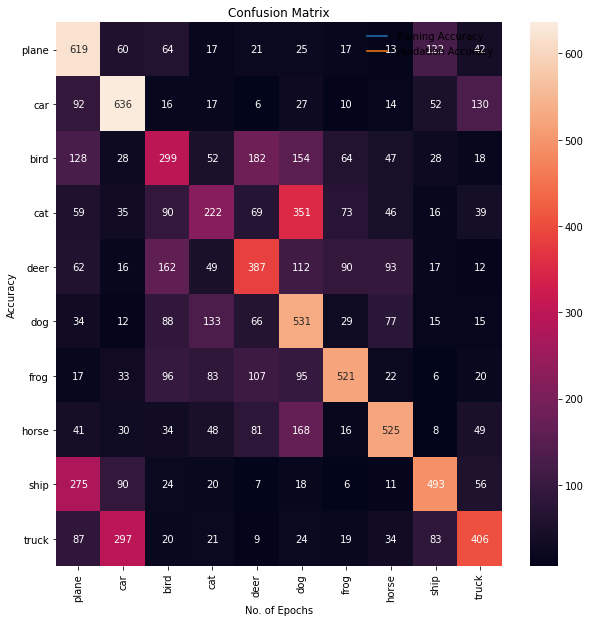

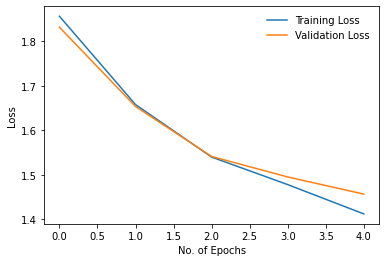

hkim - 777 
Model Loaded
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([-1.6231, -1.7527,  0.4798,  1.4290,  0.8641,  0.6014,  1.4224,  0.4554,
        -2.4728, -0.5440], grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


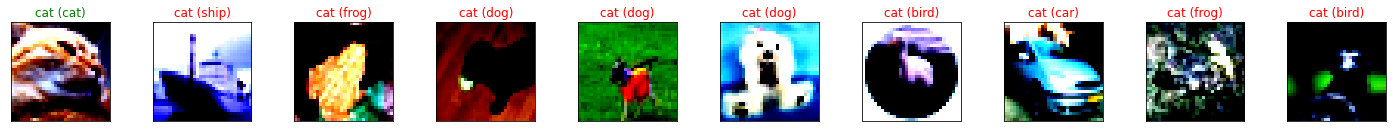

In [8]:
# 1. confusion matrix
#print(cm)
cm = cm.astype(int)
classes = classes_list
fig, ax = plt.subplots(figsize=(10,10))  
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d")
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(classes,rotation=90)
ax.yaxis.set_ticklabels(classes,rotation=0)


# 2. learning curve
plt.plot(training_history['accuracy'],label="Training Accuracy")
plt.plot(validation_history['accuracy'],label="Validation Accuracy")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend(frameon=False)
plt.show()

plt.plot(training_history['loss'],label="Training Loss")
plt.plot(validation_history['loss'],label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

print("hkim - 777 ")

# 3. load the saved model and draw sample prediction results
def fetch_last_checkpoint_model_filename(model_save_path):
    import os
    checkpoint_files = os.listdir(model_save_path)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return os.path.join(model_save_path, checkpoint_files[last_idx])

model = models.resnet18()
num_classes = 10
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('./saved_models')))
print("Model Loaded")    


test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),])
testset = torchvision.datasets.CIFAR10(root=config["data_path"], train=False, download=True, transform=test_transform)
# not autoloader this time...
testloader = torch.utils.data.DataLoader(testset, batch_size=config["batch_size"], shuffle=True)

images, labels = next(iter(testloader))

model.to(idist.device())

#from torchsummary import summary
#summary(model, input_size=(3,32,32), device=idist.device().type)

preds = model(images.to(idist.device()))

preds = preds.cpu()
print(preds[0])

# plotting the results
fig = plt.figure(figsize=(25,4))
for i in range(10):
    best = np.argmax(preds[0].detach().numpy())
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    ax.set_title("{} ({})".format(classes_list[best], classes_list[labels[i]]),
                color=("green" if best==labels[i] else "red"))

## License


---


Note: This is not an official [LG AI Research](https://www.lgresearch.ai/) product but sample code provided for an educational purpose

<br/>
author: John H. Kim
<br/>  
email: john.kim@lgresearch.ai / secutron@naver.com  


---